# Ciudad en quince minutos

## Educacion y salud publica
### Importar de los modulos necesarios

In [2]:
import sys
sys.path.append('..')
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import pandana as pdn
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
# import my_functions as mf
import warnings
import os
import json
from shapely.geometry import Point

warnings.filterwarnings("ignore")

In [9]:
cols = ['id', 'source', 'type', 'name', 'Category', 'Subcategory', 'geometry']

### Carga y ajuste de los puntos de interés

In [11]:
def load_education_1():
    path = '/app/data/input/educacion/escuelas_colegios/20220914_Directorio_Oficial_EE_2022_20220430_WEB.csv'
    cols = ['RBD', 'NOM_RBD', 'COD_REG_RBD', 'LATITUD', 'LONGITUD', 'ESTADO_ESTAB',]
    df = pd.read_csv(path, delimiter=';')
    # print(df.columns)
    reg_filter = df['COD_REG_RBD'] == 8 # Que sea de la región del biobio
    reg_estado = df['ESTADO_ESTAB'] == 1 # Que el establecimiento esté en funcionamiento
    reg_matriculas = df['MAT_TOTAL'] > 0 # Que el numero de matriculas sea mayor a 0

    ##################################################################################
    reg_municipal = df['COD_DEPE'].isin([5,6])
    # COD_DEPE -> Indica el código de quien depende el establecimiento
    # 1: Corporación Municipal
    # 2: Municipal DAEM
    # 3: Particular Subvencionado
    # 4: Particular Pagado
    # 5: Corp. De Administración Delegada (DL 3166)
    # 6: Servicio Local de Educación
    ##################################################################################

    # reg_nivel = df['']
    mask = reg_filter & reg_estado & reg_matriculas & reg_municipal
    df = df.loc[mask, cols]
    coord_cols = ['LATITUD', 'LONGITUD']
    for c in coord_cols:
        df[c]  = pd.to_numeric(df[c].str.replace(',', '.'), errors='coerce')
    df.dropna(subset=coord_cols, inplace=True)
    return df

def make_geodf_education_1():
    df = load_education_1()
    df['geometry'] = df.apply(lambda row: Point(row['LONGITUD'], row['LATITUD']), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    return gdf

gdf = make_geodf_education_1()
# display(gdf)
gdf['Category'] = "Educacion"
gdf['source'] = 'Transparencia'
gdf['id'] = gdf['RBD']
gdf['type'] = 'facilities'
gdf['Subcategory'] = "school"
gdf.rename(columns={'NOM_RBD':'name'}, inplace=True)
master_gdf = gdf[cols]

In [12]:
# Educacion Superior
gdf = gpd.read_file('/app/data/input/educacion/superior')
gdf['Category'] = "Educacion"
gdf['source'] = 'CityLab'
gdf['id'] = gdf['Id']
gdf['type'] = 'facilities'
gdf['Subcategory'] = gdf['Tipo'].str.capitalize()
gdf.rename(columns={'Nombre':'name'}, inplace=True)
master_gdf = pd.concat([master_gdf, gdf[cols]])

In [14]:
def load_salud():
    path = '/app/data/input/salud/Est_Salud_14_Mayo_2021.xlsx'
    df = pd.read_excel(path)
    cols = ['c_VIG', 'C_REG', 'DEPEN_A', 'NOMBRE', 'LATITUD', 'LONGITUD']
    depende_a = [
        'Servicio de Salud',
        'Municipal',
        'Otra Institución',
    ]

    df = df[df['C_REG']==8]
    df = df[df['DEPEN_A'].isin(depende_a)]
    return df[cols]

def make_geodf_salud():
    df = load_salud()
    df['geometry'] = df.apply(lambda row: Point(row['LONGITUD'], row['LATITUD']), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    return gdf

gdf = make_geodf_salud()
gdf['Category'] = "Cuidados"
gdf['source'] = 'Transparencia'
gdf['id'] = gdf['c_VIG']
gdf['type'] = 'health_services'
gdf['Subcategory'] = gdf['DEPEN_A']
gdf.rename(columns={'NOMBRE':'name'}, inplace=True)
master_gdf = pd.concat([master_gdf, gdf[cols]])

#### Guardado de los puntos de interes

In [15]:
master_gdf.to_file('/app/data/input/lugares_interes_publicos')

### Carga del grafo (si no existe, lo descarga)

In [16]:
graph = ox.graph_from_place(
    "Concepción, Chile",
    network_type="walk",
    simplify=False,
)

#### Extracción de los nodos y enlaces

In [17]:
def get_nodes_and_edges_df(graph):
    nodes_df, edges_df = ox.graph_to_gdfs(graph)
    nodes_df = nodes_df.rename(columns={'x': 'lon', 'y': 'lat'})
    nodes_df['id'] = nodes_df.index
    edges_df['from'] = edges_df.reset_index()['u'].values
    edges_df['to'] = edges_df.reset_index()['v'].values
    return nodes_df, edges_df

nodes_df, edges_df = get_nodes_and_edges_df(graph)

#### Definir red en Pandana

In [18]:
# search_radius = 1000
net = pdn.Network(
    nodes_df['lon'],
    nodes_df['lat'],
    edges_df['from'],
    edges_df['to'],
    edges_df[['length']]
)
# net.precompute(search_radius)

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 36785
Setting CH edge vector of size 81070
Range graph removed 81070 edges of 162140
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


### Calculo de las matrices de ruteo

In [20]:
# pois: corresponde a los puntos de interés para el estudio
# grid: corresponde a un conjunto de polígonos que dividen la ciudad en una grilla.
grid = gpd.read_file('/app/data/input/grilla50_urbano_extendido').to_crs(4326)
pois = gpd.read_file('/app/data/input/lugares_interes_publicos').to_crs(4326)
amcs = gpd.read_file('/app/data/input/area_metropolitana_conce').to_crs(4326)

# Filtrar los puntos de interes que estén solo en el radio urbano
pois = gpd.sjoin(pois, amcs, op='within')
pois['pois_id'] = pois['type'].str[0] + pois['id'].astype(str)

# Ajuste de la grilla y sus 'id'
grid.drop(['Id'], axis='columns', inplace=True)
grid['grid_id'] = grid.index

# Agrega el centroide a la grilla y los puntos (x,y)
grid['centroid'] = grid['geometry'].centroid
grid['x'] = grid['centroid'].x
grid['y'] = grid['centroid'].y

# Agrega los puntos (x,y) de los pois
pois['x'] = pois['geometry'].x
pois['y'] = pois['geometry'].y


# # TESTEOOOOOOOOOO
# x_min, x_max = -73.04, -73.02
# y_min, y_max = -36.82, -36.8
# mask_x = (grid['x'] >= x_min)&(grid['x'] <= x_max)
# mask_y = (grid['y'] >= y_min)&(grid['y'] <= y_max)
# mask = mask_x & mask_y

# grid = grid[mask]

In [21]:
grid['nearest_node'] = net.get_node_ids(grid['x'], grid['y'])
pois['nearest_node'] = net.get_node_ids(pois['x'], pois['y'])

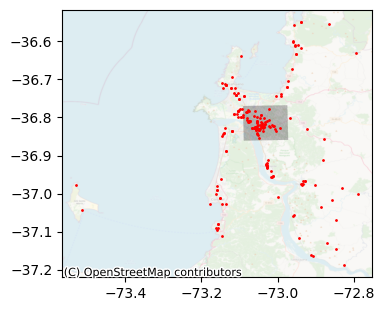

In [22]:
size = 4
fig, ax = plt.subplots(figsize=(size,size))
grid.plot(ax=ax, facecolor='gray', alpha=0.5)
pois.plot(ax=ax, color='red', markersize=1)
# Agrega un mapa de fondo utilizando contextily
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=grid.crs.to_string(),
    alpha=0.4
)
plt.show()

In [23]:
categories = pois['Category'].unique()

routing_matrix_raw = {}
total_origin_nodes = grid.shape[0]
grid_node_cols = ['grid_id', 'nearest_node']
pois_node_cols = ['pois_id', 'nearest_node']
for category in categories:
    # pivot_tables = []
    raw_tables = []
    # print(f'En la categoria {category}')
    mask = pois['Category']==category
    dest_cols = []
    destination = pois.loc[mask, pois_node_cols]
    total_destination = len(destination)
    grid_node = grid[grid_node_cols]

    for k, (_, row) in enumerate(grid_node.iterrows()):
        print(f'\t{category} : En el nodo {k} de {total_origin_nodes}')
        origin_node = row['nearest_node']
        origin_nodes = [origin_node]*total_destination
        destination_nodes = destination['nearest_node'].values
        shortest_path_lengths = net.shortest_path_lengths(origin_nodes, destination_nodes)
        data = {
            'origin': origin_nodes,
            'destination': destination_nodes,
            'path_lengths': shortest_path_lengths,
        }
        node_path_lengths = pd.DataFrame.from_dict(data)
        node_path_lengths['grid_id'] = row['grid_id']
        node_path_lengths.sort_values(by=['path_lengths'], inplace=True)
        node_path_lengths = node_path_lengths.head(25)
        node_path_lengths.reset_index(drop=True, inplace=True)
        node_path_lengths['rank'] = node_path_lengths.index
        node_path_lengths = pd.merge(node_path_lengths, destination.rename(columns={'nearest_node': 'destination'}), on='destination')
        raw_tables.append(node_path_lengths)

        # pivot_table = node_path_lengths.pivot_table(index=['grid_id', 'origin'], columns='destination', values='path_lengths')
        # pivot_tables.append(pivot_table)
        pass

    # routing_matrix_raw[category] = pd.concat(raw_tables)
    routes = pd.concat(raw_tables)
    #22/08/2023 agregado "_full" para indicar que se usó el grafo sin simplificar
    # routes.to_pickle(f'/app/data/output/routing_matrix/{category}_full.pkl')
    routes.to_pickle(f'/app/data/output/routing_matrix/{category}_publico.pkl')

    # [routes.to_pickle(f'/app/data/output/routing_matrix/{category}.pkl') for category, routes in routing_matrix_raw.items()];
    # routing_matrix_pivot[category] = pd.concat(pivot_tables)
    pass

	Educacion : En el nodo 0 de 42016
	Educacion : En el nodo 1 de 42016
	Educacion : En el nodo 2 de 42016
	Educacion : En el nodo 3 de 42016
	Educacion : En el nodo 4 de 42016
	Educacion : En el nodo 5 de 42016
	Educacion : En el nodo 6 de 42016
	Educacion : En el nodo 7 de 42016
	Educacion : En el nodo 8 de 42016
	Educacion : En el nodo 9 de 42016
	Educacion : En el nodo 10 de 42016
	Educacion : En el nodo 11 de 42016
	Educacion : En el nodo 12 de 42016
	Educacion : En el nodo 13 de 42016
	Educacion : En el nodo 14 de 42016
	Educacion : En el nodo 15 de 42016
	Educacion : En el nodo 16 de 42016
	Educacion : En el nodo 17 de 42016
	Educacion : En el nodo 18 de 42016
	Educacion : En el nodo 19 de 42016
	Educacion : En el nodo 20 de 42016
	Educacion : En el nodo 21 de 42016
	Educacion : En el nodo 22 de 42016
	Educacion : En el nodo 23 de 42016
	Educacion : En el nodo 24 de 42016
	Educacion : En el nodo 25 de 42016
	Educacion : En el nodo 26 de 42016
	Educacion : En el nodo 27 de 42016
	E

#### Lectura de las matrices de ruteo

In [24]:
def read_top_amenities():
    dfs = []
    for category in categories:
        df = pd.read_pickle(f'/app/data/output/routing_matrix/{category}_publico.pkl')
        df = df[(df['rank']==0)&(df.index==0)]
        df['Category'] = category
        # display(df[df.index==1])
        dfs.append(df)
    return pd.concat(dfs)

df = read_top_amenities()

In [25]:
def calcular_tiempo(distancia_metros):
    velocidad_kph = 5

    # Convertir la velocidad a metros por minuto
    velocidad_mpm = velocidad_kph * 1000 / 60
    
    # Calcular el tiempo en minutos
    tiempo = (distancia_metros / velocidad_mpm)
    
    return tiempo

df['travel_time'] = df['path_lengths'].apply(calcular_tiempo)

In [27]:
df.to_pickle('/app/data/output/top_amenities_publico.pkl')

In [33]:
df = pd.read_pickle('/app/data/output/top_amenities_publico.pkl')

In [38]:
filter_area = gpd.read_file('/app/data/input/limite_urbano_ccp_utm')

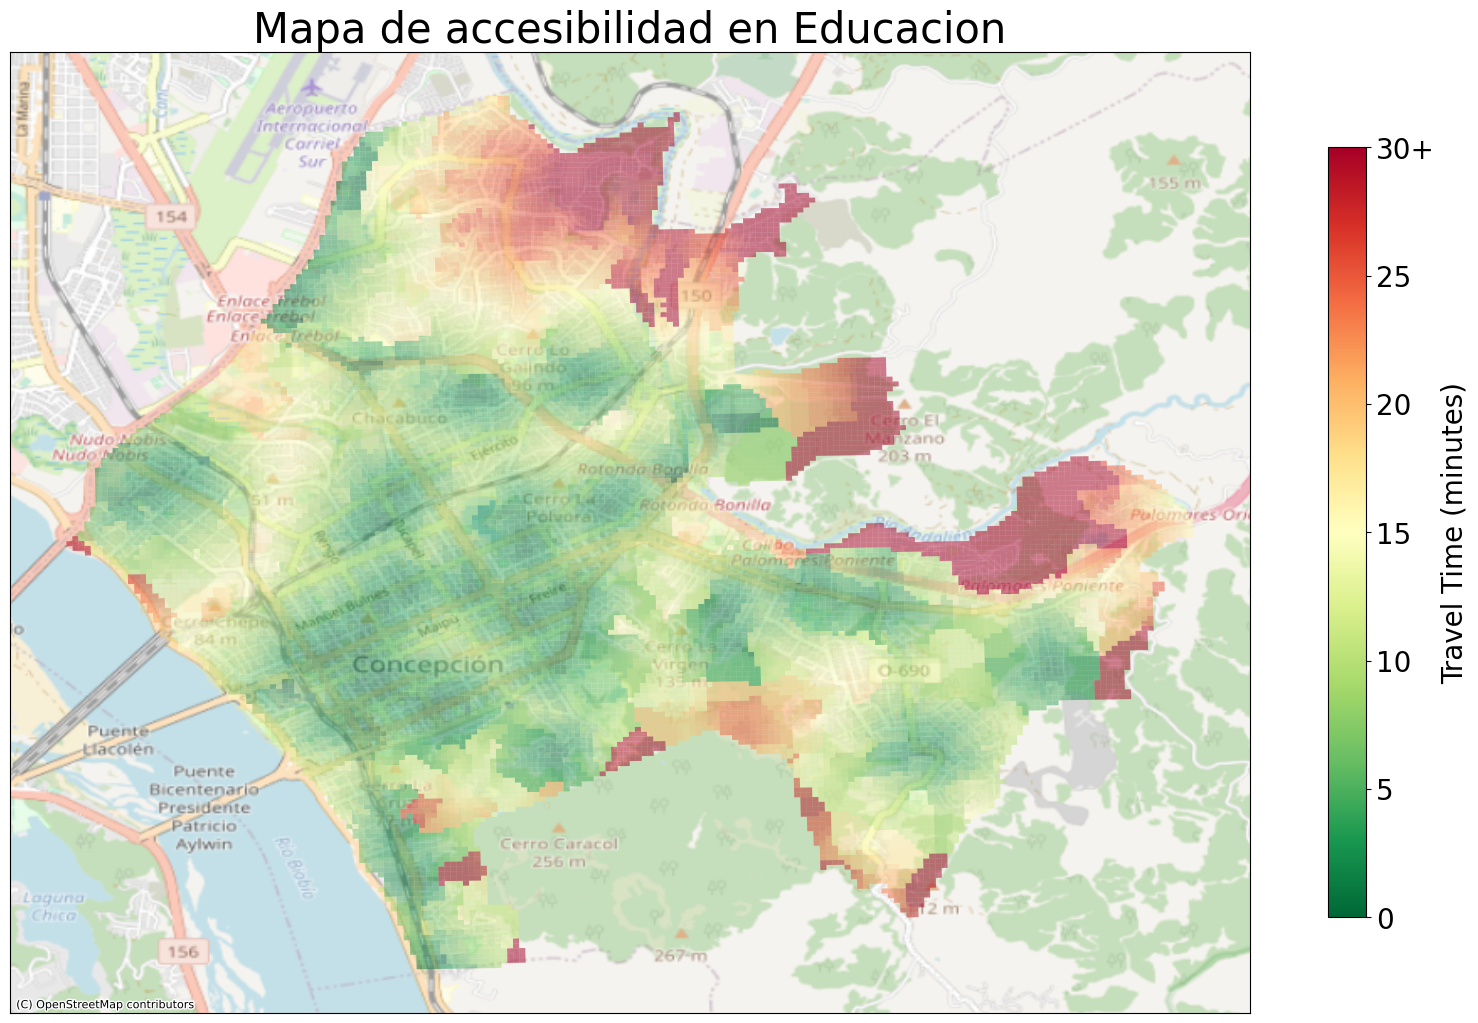

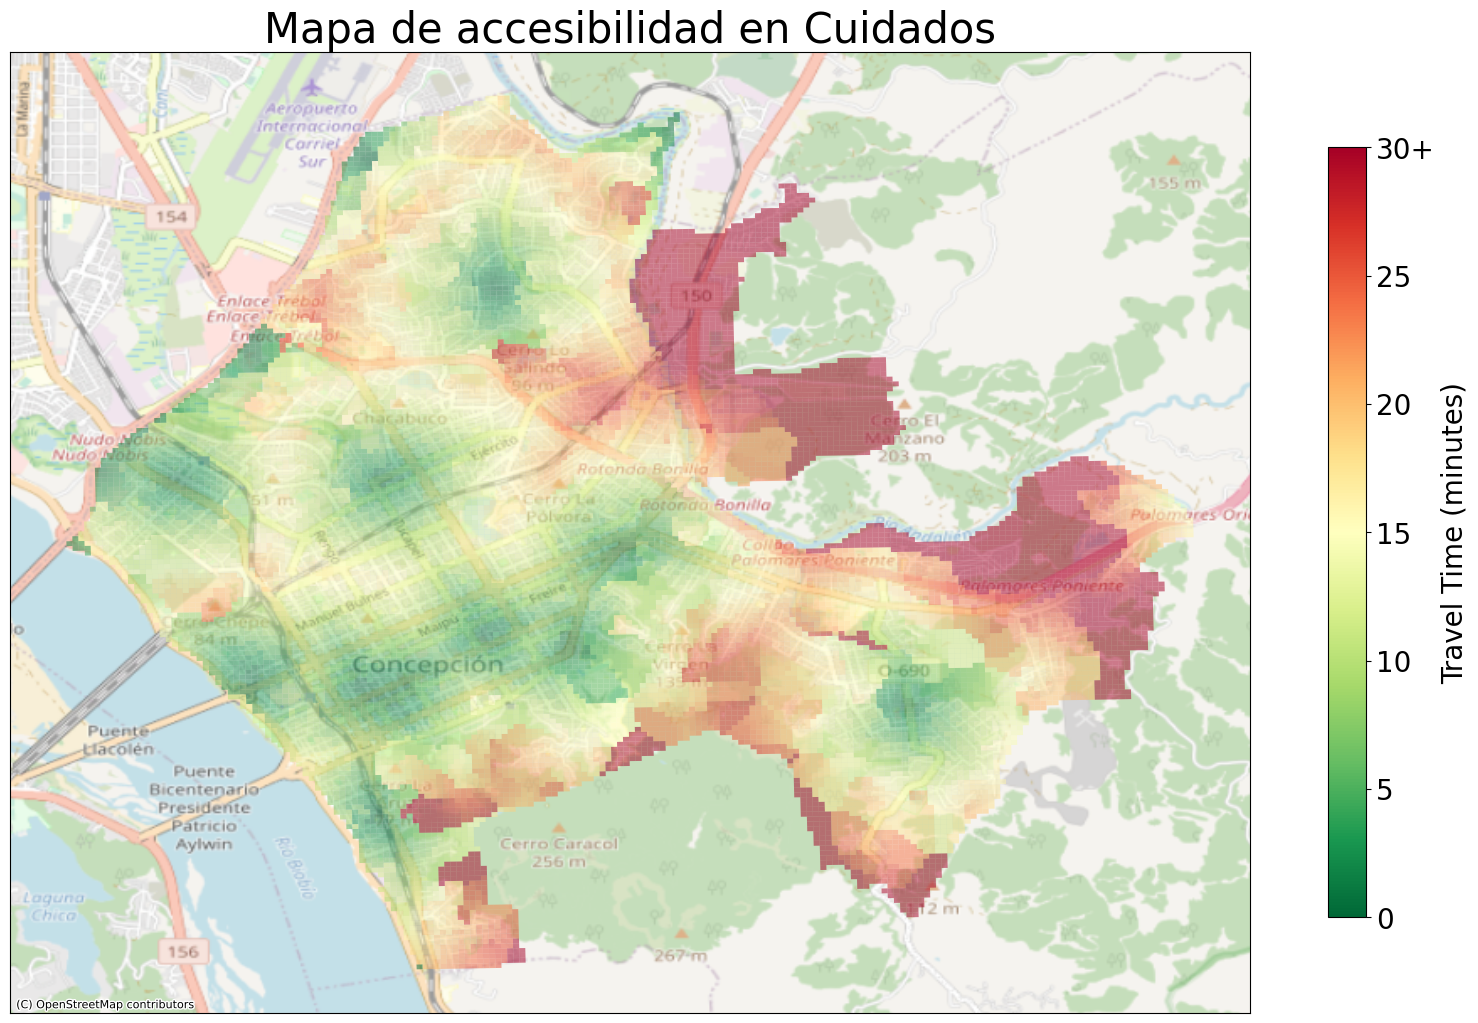

In [42]:
import matplotlib.colors as mcolors

category = ['Educacion', 'Cuidados']
map_cols = ['grid_id', 'Category', 'travel_time']

for category in categories:

    gdf = pd.merge(grid, df.loc[df['Category']==category, map_cols], on='grid_id')
    gdf = gpd.sjoin(gdf, filter_area.to_crs(gdf.crs), op='within')
    exp_category = category.replace(' ', '_')
    exp_cols = ['grid_id', 'travel_time', 'geometry']
    gdf[exp_cols].to_file(f'/app/data/output/amenities_maps/ServPublicos/{exp_category}')

    (h, w) = (20, 20)
    fig, ax = plt.subplots(figsize=(h, w))

    # Rango deseado para la escala de colores
    vmin = 0
    vmax = 30
    cmap = 'RdYlGn_r'  # Utilizamos el colormap 'RdYlBu'

    # Normalizar los valores de 'travel_time' para asegurar que estén dentro del rango de colores
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    # Plotear las geometrías con los colores según 'travel_time'
    gdf.plot(ax=ax, column='travel_time', cmap=cmap, linewidth=0.8, edgecolor='none', norm=norm, alpha=0.5)

    # Ajustar la escala de la barra de colores
    cbar = fig.colorbar(mapper, shrink=0.5)
    cbar.set_label('Travel Time (minutes)', size=20)  # Etiqueta de la barra de colores
    ticks = np.arange(vmin, vmax+1, 5)
    cbar.set_ticks(ticks)  # Puedes personalizar los ticks de la barra
    str_ticks = [str(n) for n in ticks]
    str_ticks[-1] = f'{vmax}+'
    cbar.set_ticklabels(str_ticks)  # Personalizar los valores de los ticks
    cbar.ax.tick_params(labelsize=20)

    # Agrega un mapa de fondo utilizando contextily
    ctx.add_basemap(
        ax=ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs=gdf.crs.to_string(),
        alpha=0.7
    )
    plt.title(f'Mapa de accesibilidad en {category}', size=30)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'/app/data/output/amenities_maps/imgs/{exp_category}_publico.png')
    # plt.show()

In [52]:
dfs = []
for category in categories:
    gdf = gpd.read_file(f'/app/data/output/amenities_maps/ServPublicos/{category}')
    df = gdf[['grid_id', 'travel_tim']]
    df['category'] = category
    dfs.append(df)
df = pd.concat(dfs)

In [55]:
# Definir los valores de referencia
thresholds = [5, 10, 15]

# Función para calcular el porcentaje de muestras en un rango dado
def calculate_percentage(samples, total):
    return (samples / total) * 100
for category in df['category'].unique():
    category_df = df[df['category'] == category]
    total_samples = len(category_df)
    print(f"Categoría: {category}")
    for i in range(len(thresholds) + 1):
        if i == 0:
            samples = len(category_df[category_df['travel_tim'] < thresholds[i]])
            percentage = calculate_percentage(samples, total_samples)
            print(f"Menores a {thresholds[i]}: {percentage:.2f}%")
        elif i == len(thresholds):
            samples = len(category_df[category_df['travel_tim'] > thresholds[-1]])
            percentage = calculate_percentage(samples, total_samples)
            print(f"Mayores a {thresholds[-1]}: {percentage:.2f}%")
        else:
            samples = len(category_df[(category_df['travel_tim'] >= thresholds[i-1]) & (category_df['travel_tim'] <= thresholds[i])])
            percentage = calculate_percentage(samples, total_samples)
            print(f"Entre {thresholds[i-1]} y {thresholds[i]}: {percentage:.2f}%")
    print()

Categoría: Educacion
Menores a 5: 23.10%
Entre 5 y 10: 29.09%
Entre 10 y 15: 18.64%
Mayores a 15: 29.17%

Categoría: Cuidados
Menores a 5: 9.59%
Entre 5 y 10: 18.53%
Entre 10 y 15: 22.15%
Mayores a 15: 49.72%



count    16473.000000
mean        17.560693
std         12.796797
min          0.000000
25%          9.209076
50%         14.948796
75%         21.291024
max         70.596552
Name: travel_tim, dtype: float64